## Install the tool
sage_data_client Python package needs to be installed to query data from Waggle data repository

In [1]:
!pip3 install sage_data_client matplotlib

DEPRECATION: Loading egg at /usr/local/Cellar/gpgme/1.22.0/lib/python3.11/site-packages/gpg-1.22.0-py3.11-macosx-13-x86_64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


## Pull and plot CPU utilization of a Waggle node
We will pull CPU utilization of a Waggle node, named `W023`, from the repository.

In [2]:
from sage_data_client import query
import matplotlib.pyplot as plt

In [3]:
time_window = "-1h"
df_cpu = query(
    bucket="grafana-agent", # the performance data are stored in this bucket
    start=time_window,      # query the last 1 hour data
    filter={
        "name": "tegra_cpu_util_percentage", # name of the metric
        "vsn": "W023",                       # name of the Waggle node
    },
)
df_power = query(
    bucket="grafana-agent",
    start=time_window,
    filter={
        "name": "tegra_wattage_current_milliwatts",
        "vsn": "W023",
    },
)

The data looks like,

In [4]:
df_cpu.head()

,timestamp,name,value,meta.cluster,meta.container,meta.cpu,meta.endpoint,meta.host,meta.hostname,meta.instance,meta.job,meta.metrics_path,meta.namespace,meta.pod,meta.vsn
0,2024-01-19 18:20:50.129000+00:00,tegra_cpu_util_percentage,15,default/grafana-agent,jetson-exporter,1,9101,beehive-grafana-agent-loader-5cd8d95697-9zbcf,000048b02d15bc7c.ws-nxcore,10.42.0.220:9101,integrations/kubernetes/pod,/metrics,default,wes-jetson-exporter-df4pd,W023
1,2024-01-19 18:22:50.129000+00:00,tegra_cpu_util_percentage,23,default/grafana-agent,jetson-exporter,1,9101,beehive-grafana-agent-loader-5cd8d95697-9zbcf,000048b02d15bc7c.ws-nxcore,10.42.0.220:9101,integrations/kubernetes/pod,/metrics,default,wes-jetson-exporter-df4pd,W023
2,2024-01-19 18:24:50.129000+00:00,tegra_cpu_util_percentage,21,default/grafana-agent,jetson-exporter,1,9101,beehive-grafana-agent-loader-5cd8d95697-9zbcf,000048b02d15bc7c.ws-nxcore,10.42.0.220:9101,integrations/kubernetes/pod,/metrics,default,wes-jetson-exporter-df4pd,W023
3,2024-01-19 18:26:50.129000+00:00,tegra_cpu_util_percentage,59,default/grafana-agent,jetson-exporter,1,9101,beehive-grafana-agent-loader-5cd8d95697-9zbcf,000048b02d15bc7c.ws-nxcore,10.42.0.220:9101,integrations/kubernetes/pod,/metrics,default,wes-jetson-exporter-df4pd,W023
4,2024-01-19 18:28:50.129000+00:00,tegra_cpu_util_percentage,37,default/grafana-agent,jetson-exporter,1,9101,beehive-grafana-agent-loader-5cd8d95697-9zbcf,000048b02d15bc7c.ws-nxcore,10.42.0.220:9101,integrations/kubernetes/pod,/metrics,default,wes-jetson-exporter-df4pd,W023


The wattage values are measured from 3 different sensors in the device,

In [5]:
print(f'Sensors are {list(df_power["meta.sensor"].unique())}')

Sensors are ['vdd_cpu_gpu_cv', 'vdd_in', 'vdd_soc']


Let's plot CPU utilization of the node along with the power consumption of the device,

Text(0.5, 1.0, 'Power consumption of CPU/GPU on the device')

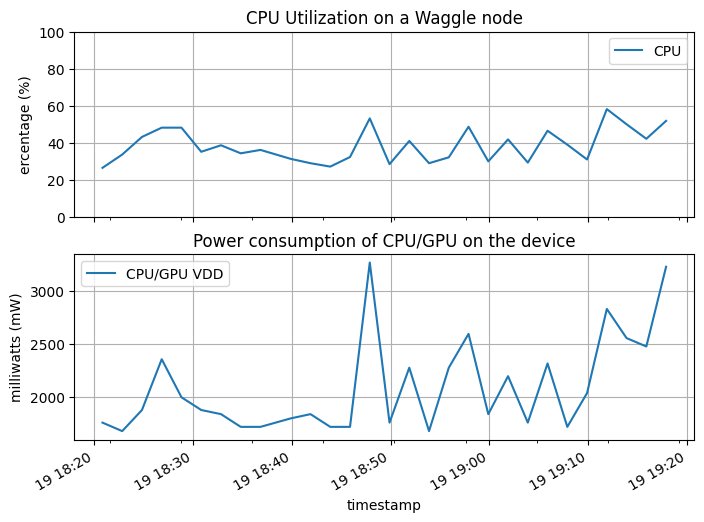

In [6]:
fig, ax = plt.subplots(2, figsize=(8,6), sharex=True)
# tegra_cpu_utilization_percentage shows CPU utilization per logical core in the Waggle node.
# We take the averaged CPU utilization of all the cores to show the overall utilization.
df_cpu.groupby("timestamp")["value"].mean().reset_index().plot(ax=ax[0], x="timestamp", y="value", label="CPU")
ax[0].grid()
ax[0].set_ylim([0, 100])
ax[0].set_ylabel("ercentage (%)")
ax[0].set_title("CPU Utilization on a Waggle node")

df_power[df_power["meta.sensor"] == "vdd_cpu_gpu_cv"][["timestamp", "value"]].plot(ax=ax[1], x="timestamp", y="value", label="CPU/GPU VDD")
ax[1].grid()
ax[1].set_ylabel("milliwatts (mW)")
ax[1].set_title("Power consumption of CPU/GPU on the device")